Loading database at ../datasets/ant_world/routes/ant1_route1...
Database contains 812 images
Starting get_ann()...
Seed for InfoMax net: 42
get_ann() took 96.5518 s to run (without caching)
Saving result to cache '.navbench_cache/3469126272.py_get_ann_99a35c3a9988619052b7295fa9ab1a7924f378f40396d0b2e704092ec8c73cbc.pkl'
Starting get_heads_infomax()...
get_heads_infomax() took 3.32246 s to run (without caching)
Saving result to cache '.navbench_cache/3469126272.py_get_heads_infomax_8f25e493b1a74be930f5ac5d271b08db44c157b8c766b5de38880f68a514a356.pkl'
Starting get_heads_ridf()...
get_heads_ridf() took 23.8771 s to run (without caching)
Saving result to cache '.navbench_cache/3469126272.py_get_heads_ridf_8b91e798a40a2d19d8ad9aa811fae190f8053171812df264423c32f58b200960.pkl'


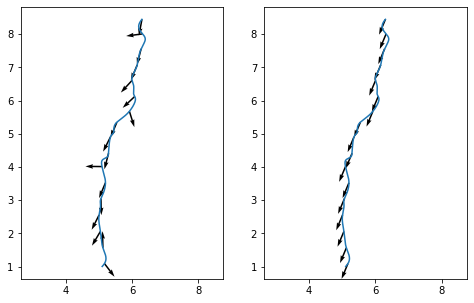

In [1]:
import sys
sys.path.append('..')

import math
import os

import matplotlib.pyplot as plt
import numpy as np
import pathos.multiprocessing as mp

import navbench as nb
import navbench.imgproc as ip
from navbench.infomax import InfoMax

IM_SIZE = (90, 25)
PREPROC = ip.resize(*IM_SIZE)

db = nb.Database('../datasets/ant_world/routes/ant1_route1')
images = db.read_images(preprocess=PREPROC, to_float=False)

@nb.cache_result
def get_ann(images, im_size, lrate, seed):
    assert not seed is None

    ann = InfoMax(im_size[0] * im_size[1], learning_rate=lrate, seed=seed)
    for im in images:
        ann.train(im)
    return ann

@nb.cache_result
def get_heads_infomax(ann, test_images):
    head_offset = db.calculate_heading_offset(0.25)
    pool = mp.Pool()
    return pool.map(lambda im: head_offset + nb.ridf_to_radians(ann.ridf(im)), test_images)

def get_best_ridf(diffs):
    best_over_rot = np.min(diffs, axis=1)
    best_row = np.argmin(best_over_rot)
    return diffs[best_row, :]

@nb.cache_result
def get_heads_ridf(snapshots, test_images):
    head_offset = db.calculate_heading_offset(0.25)
    heads = [head_offset + nb.ridf_to_radians(get_best_ridf(nb.ridf(snapshots, im))) for im in test_images]
    return heads

ann = get_ann(images, IM_SIZE, InfoMax.DEFAULT_LEARNING_RATE, 42)

test_entries = range(0, len(db), 50)
x = [db.x[i] for i in test_entries]
y = [db.y[i] for i in test_entries]
heads = get_heads_infomax(ann, [images[entry] for entry in test_entries])
u = [math.cos(head) for head in heads]
v = [math.sin(head) for head in heads]

_, ax = plt.subplots(1, 2, figsize=(8, 5))

ax[0].plot(db.x, db.y)
ax[0].quiver(x, y, u, v, angles='xy', scale_units='xy', scale=2)
ax[0].axis('equal')

heads = get_heads_ridf(images, [images[entry] for entry in test_entries])
u = [math.cos(head) for head in heads]
v = [math.sin(head) for head in heads]

ax[1].plot(db.x, db.y)
ax[1].quiver(x, y, u, v, angles='xy', scale_units='xy', scale=2)
ax[1].axis('equal');